In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm

file_paths = []
labels = []


image_dir = Path('/kaggle/input/deepfake-and-real-images/Dataset/')

for image_file in tqdm(sorted(image_dir.glob('*/*/*.*')), desc="Processing Images"):
    # Extract the label from the file path (parent folder name)
    label = image_file.parent.name
    labels.append(label)
    file_paths.append(str(image_file))

print(f"Total Images: {len(file_paths)}, Total Labels: {len(labels)}")


df = pd.DataFrame({
    "image": file_paths,
    "label": labels
})


print(f"DataFrame Shape: {df.shape}")

df.head()

Processing Images: 100%|██████████| 190335/190335 [00:00<00:00, 313308.73it/s]


Total Images: 190335, Total Labels: 190335
DataFrame Shape: (190335, 2)


,image,label
0,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
1,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
2,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
3,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
4,/kaggle/input/deepfake-and-real-images/Dataset...,Fake


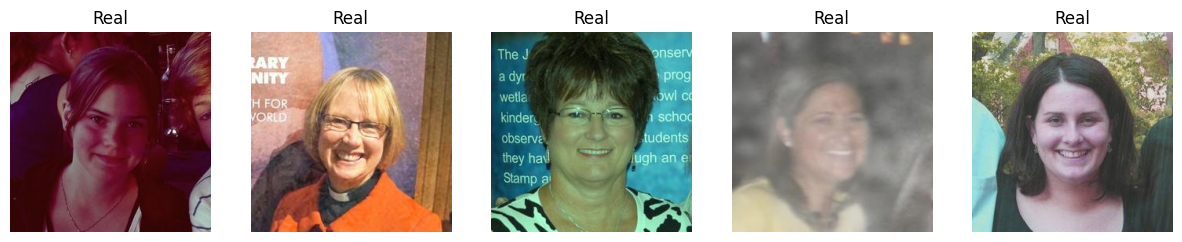

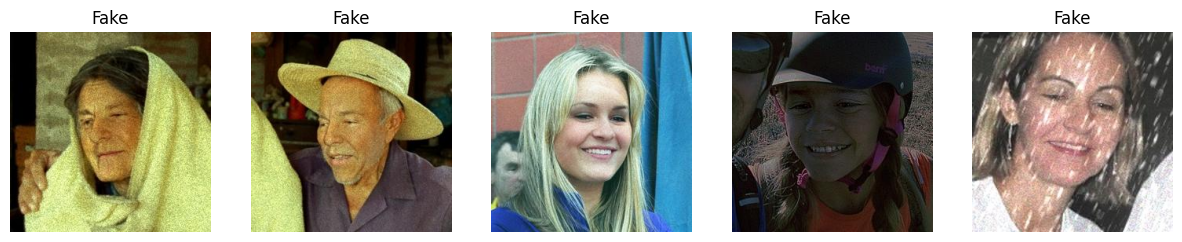

In [3]:
import matplotlib.pyplot as plt
import cv2

# Display images for a given label (Real or Fake)
def display_images(label, num_images=5):
    # Filter dataframe for the given label
    filtered_df = df[df['label'] == label].head(num_images)
    
    # Set up the figure for displaying images
    plt.figure(figsize=(15, 5))
    
    for idx, row in enumerate(filtered_df.itertuples()):
        # Read the image file
        image = cv2.imread(row.image)
        # Convert from BGR to RGB (since OpenCV reads images in BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display the image
        plt.subplot(1, num_images, idx+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    
    # Show the images
    plt.show()

# Display 5 'Real' images
display_images('Real', num_images=5)

# Display 5 'Fake' images
display_images('Fake', num_images=5)


In [4]:
df['label'].unique()
print("Class Distribution:")
print(df['label'].value_counts())

Class Distribution:
label
Real    95201
Fake    95134
Name: count, dtype: int64


In [5]:
# Randomly sample 1/10th of the DataFrame
df_sampled = df.sample(frac=0.1, random_state=42)

# Optionally, reset the index if needed
df_sampled.reset_index(drop=True, inplace=True)

# Display the shape of the sampled DataFrame
print(f"Sampled DataFrame Shape: {df_sampled.shape}")

# Show the class distribution in the sampled DataFrame
print("Sampled Class Distribution:")
print(df_sampled['label'].value_counts())


Sampled DataFrame Shape: (19034, 2)
Sampled Class Distribution:
label
Real    9547
Fake    9487
Name: count, dtype: int64


In [6]:
train_data = pd.read_csv('/kaggle/input/resized/train_resized_images.csv')

In [7]:
print(train_data.columns)


Index(['label', 'flattened_image'], dtype='object')


 HOG FEATURE EXTRACTION

In [8]:
import pandas as pd
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
import os

# Load the CSV file
train_data = pd.read_csv('/kaggle/input/resized/train_resized_images.csv')

# Function to convert flattened string back to a 48x48 image
def convert_flattened_string_to_image(flat_string):
    # Convert the string of flattened array into a numpy array
    flat_array = np.fromstring(flat_string, sep=',')
    # Reshape it to 48x48
    image = flat_array.reshape(48, 48)
    return image


def extract_hog_features(image):

    hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features

# Initialize lists for the new DataFrame
extracted_features = []
labels = []

for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    image = convert_flattened_string_to_image(row['flattened_image']) 
    features = extract_hog_features(image)
    extracted_features.append(features)
    labels.append(row['label'])


label_mapping = {'Real': 0, 'Fake': 1}
mapped_labels = [label_mapping[label] for label in labels]


extracted_features_df = pd.DataFrame(extracted_features)
extracted_features_df['label'] = mapped_labels

output_file = '/kaggle/working/train_extracted_features_hog48.csv'
extracted_features_df.to_csv(output_file, index=False)

print(f"Extracted features saved to {output_file}")


100%|██████████| 14000/14000 [02:10<00:00, 107.19it/s]


Extracted features saved to /kaggle/working/train_extracted_features_hog48.csv


In [9]:

saved_data = pd.read_csv(output_file)
num_rows, num_columns = saved_data.shape
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")


Number of rows: 14000, Number of columns: 901


In [10]:
unique_labels = saved_data['label'].unique()
print(f"Unique values in the label column: {unique_labels}")

Unique values in the label column: [1 0]


LOCAL BINARY PATTERN FEATURE EXTRACTION

In [11]:
import pandas as pd
import numpy as np
from skimage.feature import local_binary_pattern
from tqdm import tqdm

# Load the CSV file
train_data = pd.read_csv('/kaggle/input/resized/train_resized_images.csv')

# LBP parameters
radius = 1  # Radius for LBP
n_points = 8 * radius  # Number of points for LBP

def convert_flattened_string_to_image(flat_string):
    flat_array = np.fromstring(flat_string, sep=',', dtype=np.uint8)  # Ensure integer type
    # Reshape it to 48x48
    image = flat_array.reshape(48, 48)
    return image
def extract_lbp_features(image):
    # Apply LBP
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum() + 1e-6  # Normalize to avoid division by zero
    return lbp_hist

extracted_features = []
labels = []


for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    # Convert the flattened string to a 48x48 image
    image = convert_flattened_string_to_image(row['flattened_image'])

    features = extract_lbp_features(image)
    extracted_features.append(features)
    labels.append(row['label'])

label_mapping = {'Real': 0, 'Fake': 1}
mapped_labels = [label_mapping[label] for label in labels]

extracted_features_df = pd.DataFrame(extracted_features)
extracted_features_df['label'] = mapped_labels

output_file = '/kaggle/working/train_extracted_features_lbp48.csv'
extracted_features_df.to_csv(output_file, index=False)

print(f"LBP features saved to {output_file}")


100%|██████████| 14000/14000 [00:10<00:00, 1313.88it/s]


LBP features saved to /kaggle/working/train_extracted_features_lbp48.csv


In [12]:
import pandas as pd
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score

# Load the training dataset
train_data = pd.read_csv('/kaggle/working/train_extracted_features_hog48.csv')


X_train = train_data.iloc[:, :-1]  
y_train = train_data.iloc[:, -1]

svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)





SVC(kernel='linear')

SVM USING HOG 

In [13]:
import pandas as pd
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report
)

# Load the test dataset
test_data = pd.read_csv('/kaggle/input/resized/test_resized_images .csv')  # Fix filename space

label_mapping = {'Real': 0, 'Fake': 1}
test_data['label'] = test_data['label'].map(label_mapping)


def convert_flattened_string_to_image(flat_string):
    flat_array = np.fromstring(flat_string, sep=',')
    return flat_array.reshape(48, 48)

def extract_hog_features(image):
    hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features

test_features = []
true_labels = []

# Loop through each row in the test dataset
for idx, row in test_data.iterrows():
    image = convert_flattened_string_to_image(row['flattened_image'])
    
    # Extract HOG features
    features = extract_hog_features(image)
    
    test_features.append(features)
    true_labels.append(row['label']) 
test_features_df = pd.DataFrame(test_features)


test_features_df.columns = X_train.columns 


predictions = svm_model.predict(test_features_df)
probs = svm_model.decision_function(test_features_df)  


accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, probs)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))


print("\nSample Predictions:")
for i, (true, pred) in enumerate(zip(true_labels, predictions)):
    if i == 10:  # Limit output to the first 10 predictions
        break
    true_label = "Real" if true == 0 else "Fake"
    predicted_label = "Real" if pred == 0 else "Fake"
    print(f"True: {true_label}, Predicted: {predicted_label}")


Accuracy: 0.66
Precision: 0.68
Recall: 0.62
F1 Score: 0.65
ROC-AUC Score: 0.73

Confusion Matrix:
[[377 164]
 [206 343]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.65      0.70      0.67       541
        Fake       0.68      0.62      0.65       549

    accuracy                           0.66      1090
   macro avg       0.66      0.66      0.66      1090
weighted avg       0.66      0.66      0.66      1090


Sample Predictions:
True: Fake, Predicted: Real
True: Fake, Predicted: Fake
True: Fake, Predicted: Fake
True: Fake, Predicted: Fake
True: Fake, Predicted: Fake
True: Fake, Predicted: Fake
True: Fake, Predicted: Fake
True: Fake, Predicted: Real
True: Fake, Predicted: Real
True: Fake, Predicted: Fake


 SVM USING LBP FEATURES

In [14]:
import pandas as pd
from sklearn import svm


lbp_data = pd.read_csv('/kaggle/working/train_extracted_features_lbp48.csv')


X = lbp_data.iloc[:, :-1]  
y = lbp_data.iloc[:, -1]   


svm_model_lbp = svm.SVC(kernel='poly', degree=3, random_state=42)  # You can change the degree as needed
svm_model_lbp.fit(X, y)


print("SVM model trained successfully on the entire dataset.")


SVM model trained successfully on the entire dataset.


In [15]:
import pandas as pd
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

test_data = pd.read_csv('/kaggle/input/resized/test_resized_images .csv')  # Ensure the file name is correct (removed extra space)

radius = 1 
n_points = 8 * radius 

def convert_flattened_string_to_image(flat_string):
    flat_array = np.fromstring(flat_string, sep=',', dtype=np.uint8)  # Ensure integer type
    # Reshape it to 48x48
    image = flat_array.reshape(48, 48)
    return image
def extract_lbp_features(image):
    # Apply LBP
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    # Compute the LBP histogram
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    # Normalize the histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum() + 1e-6  # Normalize to avoid division by zero
    return lbp_hist

# Initialize lists for the test features and true labels
test_features = []
true_labels = []

# Loop through each row in the test dataset
for idx, row in test_data.iterrows():
    # Convert the flattened string to a 48x48 image
    image = convert_flattened_string_to_image(row['flattened_image'])

    features = extract_lbp_features(image)
    test_features.append(features)
    true_labels.append(0 if row['label'] == 'Real' else 1)


test_features_df = pd.DataFrame(test_features)


predictions = svm_model_lbp.predict(test_features_df)


accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")

conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy on the test set: 0.57
Confusion Matrix:
[[420 121]
 [348 201]]


In [16]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, probs)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

conf_matrix = confusion_matrix(true_labels, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))


Accuracy: 0.57
Precision: 0.62
Recall: 0.37
F1 Score: 0.46
ROC-AUC Score: 0.73

Confusion Matrix:
[[420 121]
 [348 201]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.55      0.78      0.64       541
        Fake       0.62      0.37      0.46       549

    accuracy                           0.57      1090
   macro avg       0.59      0.57      0.55      1090
weighted avg       0.59      0.57      0.55      1090



RANDOM FOREST USING LBP

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


train_data = pd.read_csv('/kaggle/working/train_extracted_features_lbp48.csv')

X_train = train_data.drop('label', axis=1)  # Features
y_train = train_data['label']  # Labels

rf_model = RandomForestClassifier(n_estimators=4, random_state=42)
rf_model.fit(X_train, y_train)

test_data = pd.read_csv('/kaggle/input/resized/test_resized_images .csv')

radius = 1  
n_points = 8 * radius 

def convert_flattened_string_to_image(flat_string):
    flat_array = np.fromstring(flat_string, sep=',')
    return flat_array.reshape(48, 48)

def extract_lbp_features(image):
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum() + 1e-6  # Normalize to avoid division by zero
    return lbp_hist

test_features = []
true_labels = []

for idx, row in test_data.iterrows():
    image = convert_flattened_string_to_image(row['flattened_image'])
    features = extract_lbp_features(image)
    test_features.append(features)
    true_labels.append(0 if row['label'] == 'Real' else 1)

test_features_df = pd.DataFrame(test_features)

predictions = rf_model.predict(test_features_df)

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy on the test set: {accuracy:.2f}")

conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy on the test set: 0.54
Confusion Matrix:
[[384 157]
 [341 208]]


In [18]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, probs)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

conf_matrix = confusion_matrix(true_labels, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))


Accuracy: 0.54
Precision: 0.57
Recall: 0.38
F1 Score: 0.46
ROC-AUC Score: 0.73

Confusion Matrix:
[[384 157]
 [341 208]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.53      0.71      0.61       541
        Fake       0.57      0.38      0.46       549

    accuracy                           0.54      1090
   macro avg       0.55      0.54      0.53      1090
weighted avg       0.55      0.54      0.53      1090



SIFT FEATURE EXTRACTION ON A VERY SMALL DATA SAMPLE

In [19]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset_path = '/kaggle/input/deepfake-and-real-images/Dataset/Test'

real_images = []
deepfake_images = []
for subdir, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(subdir, file)
            folder_name = os.path.basename(os.path.normpath(subdir))  # Get the last folder name
            
            if folder_name.lower() == 'fake':
                deepfake_images.append(image_path)
            elif folder_name.lower() == 'real':
                real_images.append(image_path)

num_samples_per_class = 3000 
random_real_images = random.sample(real_images, min(num_samples_per_class, len(real_images)))
random_deepfake_images = random.sample(deepfake_images, min(num_samples_per_class, len(deepfake_images)))
random_images = random_real_images + random_deepfake_images
random_labels = [0] * len(random_real_images) + [1] * len(random_deepfake_images)  # 0: Real, 1: Fake

print(f"Number of real images: {len(random_real_images)}")
print(f"Number of fake images: {len(random_deepfake_images)}")



Number of real images: 3000
Number of fake images: 3000


In [20]:

sift = cv2.SIFT_create()

feature_vectors = []
feature_labels = []

print("Extracting SIFT features and computing mean vectors...")
for idx, img_path in enumerate(tqdm(random_images)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    if img is not None:
        # Detect keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            # Compute the mean of the descriptors for this image
            mean_descriptor = np.mean(descriptors, axis=0)
            feature_vectors.append(mean_descriptor)
            feature_labels.append(random_labels[idx])

feature_vectors = np.array(feature_vectors)
feature_labels = np.array(feature_labels)

print("Feature vectors shape:", feature_vectors.shape)

X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, feature_labels, test_size=0.2, random_state=42
)
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

# Make predictions and evaluate the SVM
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"SVM Accuracy: {accuracy * 100:.2f}%")
 

Extracting SIFT features and computing mean vectors...


100%|██████████| 6000/6000 [02:49<00:00, 35.38it/s]


Feature vectors shape: (5993, 128)
SVM Accuracy: 62.89%


In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

Accuracy: 0.63
Precision: 0.61
Recall: 0.63
F1 Score: 0.62
ROC-AUC Score: 0.63

Confusion Matrix:
[[391 235]
 [210 363]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.65      0.62      0.64       626
        Fake       0.61      0.63      0.62       573

    accuracy                           0.63      1199
   macro avg       0.63      0.63      0.63      1199
weighted avg       0.63      0.63      0.63      1199



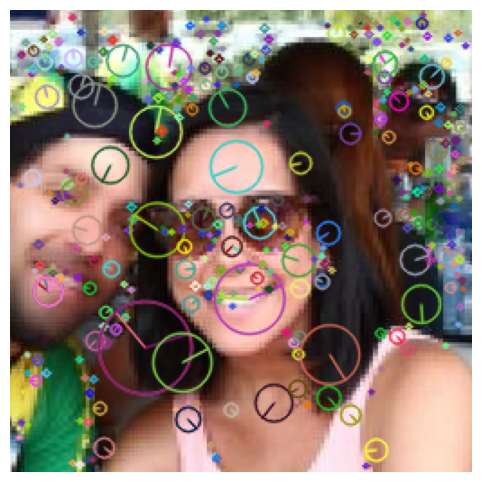

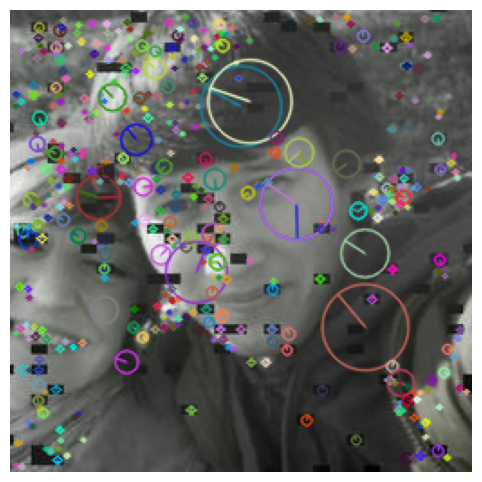

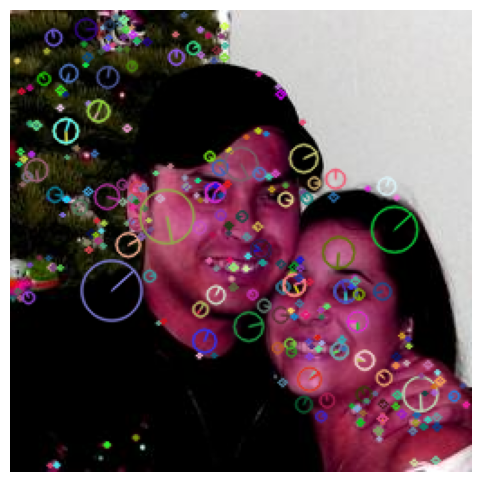

In [22]:
import matplotlib.pyplot as plt


def visualize_sift_keypoints(image_path, keypoints):
    img = cv2.imread(image_path)
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    img_rgb = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis('off') 
    plt.show()

for i in range(3):  
    img_path = random_images[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    if keypoints:
        visualize_sift_keypoints(img_path, keypoints)
